### Importing packages and data

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy import signal
import pywt
#import hfda
#import ewtpy
import pywt as py
from scipy.signal import hilbert, chirp, savgol_filter,find_peaks, peak_prominences
import statistics
#from PyEMD import EMD
import csv
import skinematics
import math
from time import sleep
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation
from skinematics.sensors.xio_ngimu import NGIMU
from skinematics.sensors.manual import MyOwnSensor
import argparse
from datetime import date
from scipy import constants
import sys
from scipy.signal import savgol_filter as sg
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from scipy import integrate
#import traja

In [7]:
os.listdir('/home/harsh/Desktop/IMU_collision_data')

['imu_26_oct_collisions_2.csv',
 'Combine_rolling_and_collisions.csv',
 'imu.csv',
 'IMU_signatures_test.ipynb',
 'imu_26_oct_rough_surface_roll.csv']

In [8]:
path = '/home/harsh/Desktop/IMU_collision_data'
file = '/imu_26_oct_collisions_2.csv'

In [9]:
data_label = pd.read_csv(path + file, encoding= 'unicode_escape')

In [10]:
data_label

,Unnamed: 0,accX,accY,accZ,gyroX,gyroY,gyroZ
0,0,0.533203,-0.195557,0.559814,39.405823,92.300415,-23.178101
1,1,0.531616,-0.102417,1.544617,53.344727,249.992371,-53.741455
2,2,0.519348,-0.125488,1.461731,54.748535,249.992371,-52.459717
3,3,0.410217,-0.205444,1.203247,54.428101,249.992371,-55.320740
4,4,0.276428,-0.236572,0.947510,52.772522,249.992371,-52.360535
...,...,...,...,...,...,...,...
69693,69693,0.296021,-0.691345,0.675232,-12.687680,-52.742004,7.400513
69694,69694,0.224609,-0.626648,0.675049,-9.292603,-34.767151,0.343323
69695,69695,0.253113,-0.588440,0.703552,-10.810850,-26.908875,-0.595093
69696,69696,0.325623,-0.566467,0.695984,-13.221740,-19.691467,-1.876831


In [11]:
test_data1 = data_label.drop(columns= 'Unnamed: 0')

### Visualizing the acceleration and gyroscope data

Text(0, 0.5, 'Force [mg]')

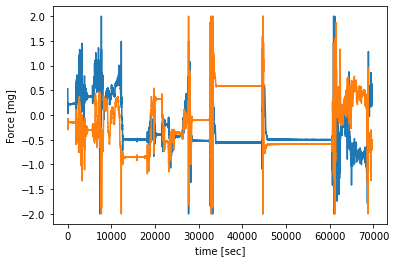

In [13]:
plt.plot(test_data1['accX'])
plt.plot(test_data1['accY'])

plt.xlabel('time [sec]')
plt.ylabel('Force [mg]')

Text(0.5, 1.0, 'angular velocity')

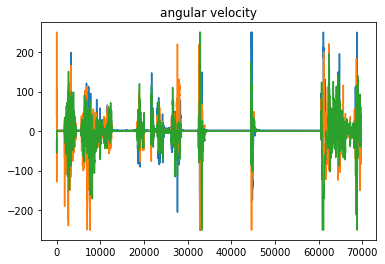

In [23]:
plt.plot(test_data1['gyroX'])
plt.plot(test_data1['gyroY'])
plt.plot(test_data1['gyroZ'])
plt.title('angular velocity')

In [14]:
x = test_data1['accX']
y = test_data1['accY']
z = test_data1['accZ']

#### Analyzing the moving variance of acc or gyro daat

In [19]:
vary_x = x.rolling(10).var()
#put any other data in place of x to see it's moving variance 
#but make sure it's a pandas series. The window of moving varinace can also be changes.

Text(0, 0.5, 'moving variance')

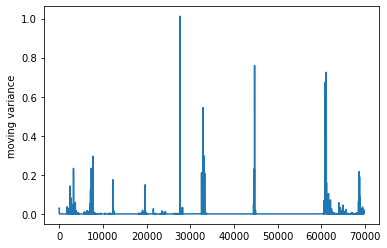

In [21]:
plt.plot(vary_x)
plt.ylabel('moving variance')

In [26]:
# converting acc and gyro data to numpy array
accX = np.array(test_data1['accX'])
accY = np.array(test_data1['accY'])
accZ = np.array(test_data1['accZ'])
gyroX = np.array(test_data1['gyroX'])
gyroY = np.array(test_data1['gyroY'])
gyroZ = np.array(test_data1['gyroZ'])

### Applying 1-D wavelet decomposition on the acc data

In [29]:
coeffs = py.wavedec(accX, 'haar', level=1)
cA1, cD1 = coeffs
# here we used haar wavelet, to find only sharper peaks we can take other wavelets but not required right now
# We used 1st level decomposition.

##### analysing the 1st decompostion of wavelet

Text(0.5, 1.0, 'wavelet 1 deco')

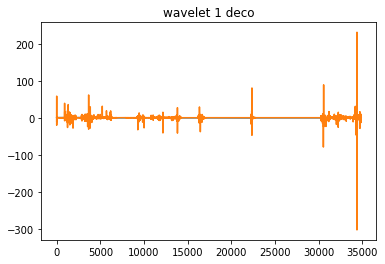

In [35]:
plt.plot(signal.decimate(accX,2))
plt.plot(cD1)
plt.title('wavelet 1 deco')

##### Note the offset is revoed by wavelets and the collision is highlighed in the data(the data due to movment of imu is reduced near 0)

### analysing the 1st decompostion on gyroscope

In [36]:
coeffs = py.wavedec(gyroX, 'haar', level=1)
cA1, cD1 = coeffs

Text(0.5, 1.0, 'wavelet 1 deco')

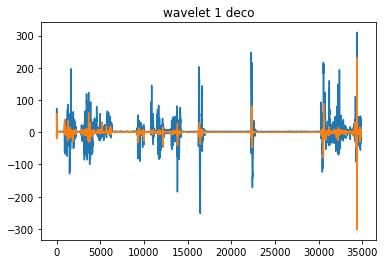

In [37]:
plt.plot(signal.decimate(gyroX,2))
plt.plot(cD1)
plt.title('wavelet 1 deco')

##### puting the different dirrection of acc and gyro to one array. (this is for estimation oriantation)

In [44]:
acc = []
gyro = []
mag = []

acc.append(accX)
acc.append(accY)
acc.append(accZ)

gyro.append(gyroX)
gyro.append(gyroY)
gyro.append(gyroZ)

In [45]:
acc = np.array(acc)
acc = (acc)/100 
gyro = np.array(gyro)
gyro = (gyro*0.0174532925)/1000 # converting from degree to radians

In [55]:
time = np.linspace(0,len(accX)/25,len(accX))
# setting time array

In [58]:
initial_orientation = np.array([[1,0,0],
                                [0,0,-1],
                                [0,1,0]])


initialPosition = [0,0,0]

rate = 25

## below is a code to find the orientation and trajectory from acc and gyro data using the skinematics package

In [60]:
pos1 = skinematics.imus.analytical(initial_orientation, np.transpose(gyro), initialPosition, np.transpose(acc), rate)

#### visualizing the quaternion 

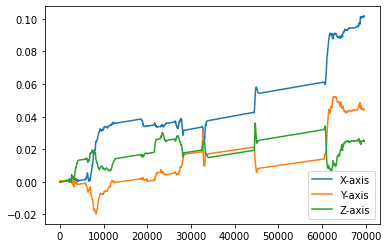

In [80]:
plt.plot(pos1[0][:,1:4])
plt.legend(["X-axis", "Y-axis","Z-axis"], loc ="lower right")

In [81]:
coeffs = py.wavedec(pos1[0][:,1], 'haar', level=1)
cA1, cD1 = coeffs

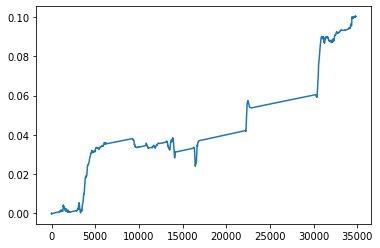

In [82]:
plt.plot(signal.decimate(pos1[0][:,1],2))

Text(0.5, 1.0, 'wavelet 1 deco')

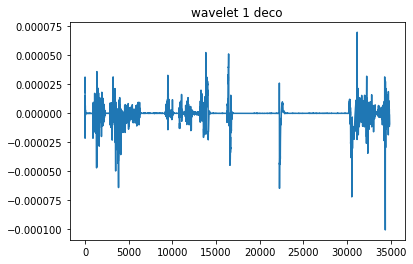

In [83]:
plt.plot(cD1)
plt.title('wavelet 1 deco')

#### visualizing the oriantion in 3-D map

/tmp/ipykernel_14916/8125484.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


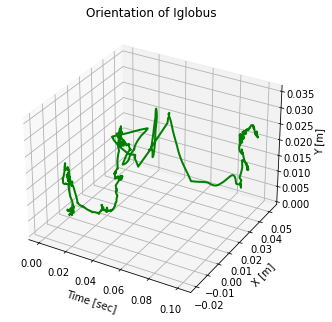

In [85]:
fig = plt.figure()
ax = Axes3D(fig)
numDataPoints = len(time)
#dataSet = np.array([x_axis, y_axis, z_axis])
# NOTE: Can't pass empty arrays into 3d version of plot()
line = plt.plot(pos1[0][:,1], pos1[0][:,2],pos1[0][:,3], lw=2, c='g')[0] # For line plot
 
# AXES PROPERTIES]
# ax.set_xlim3d([limit0, limit1])
ax.set_xlabel('Time [sec]')
ax.set_ylabel('X [m]')
ax.set_zlabel('Y [m]')
ax.set_title('Orientation of Iglobus')

plt.show()

### visualizing the oriantion in 3-D plot, (Note: This may not be accurate at all)

/tmp/ipykernel_14916/3138239809.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


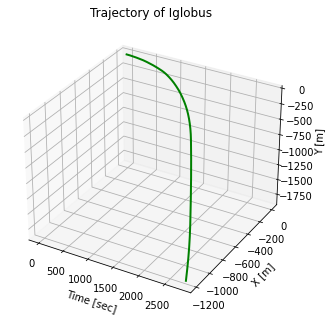

In [87]:
fig = plt.figure()
ax = Axes3D(fig)
numDataPoints = len(time)
#dataSet = np.array([x_axis, y_axis, z_axis])
# NOTE: Can't pass empty arrays into 3d version of plot()
line = plt.plot(time, pos1[1][:,0]/10, pos1[1][:,1]/10, lw=2, c='g')[0] # For line plot
 
# AXES PROPERTIES]
# ax.set_xlim3d([limit0, limit1])
ax.set_xlabel('Time [sec]')
ax.set_ylabel('X [m]')
ax.set_zlabel('Y [m]')
ax.set_title('Trajectory of Iglobus')

plt.show()